# 0. Imports and Constants
- Select user before proceeding

In [2]:
############## AUTORELOAD MAGIC ###################
%load_ext autoreload
%autoreload 2
###################################################

############## FUNDAMENTAL MODULES ################
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import json
from PIL import Image

 ##################################################

############## TASK-SPECIFIC MODULES ##############
sys.path.append("..")
from ml.datasets import VanillaDataset
from ml.models import VanillaNN
from ml.trainer import Trainer
from ml.eval import evaluate_model, write_eval_to_file, pretty_print_metrics
###################################################


####################### CONSTANTS ########################
SPLITS = ["train", "dev", "test", "gold"]
TRAIN, DEV, TEST, TXT, IMG = "train", "dev", "test", "txt", "img"
FE_METHODS = ["txt_embeddings", "img_embeddings", "concat", "sum", "mean", "hadamard"]
TRAIN, DEV, TEST, GOLD = "train", "dev", "test", "gold"
#FE_METHODS += ["concat_cos", "sum_cos", "mean_cos", "hadamard_cos"]
##########################################################

############## DATA SCIENCE & ML MODULES #################
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import classification_report
import pandas as pd
##########################################################

####################### SELECT ###########################
users = ["patriziopalmisano", "onurdenizguler", "jockl"]
user = users[1] # SELECT USER
version = "v2" # SELECT DATASET VERSION
dataset_version = version
##########################################################

if user in users[:2]:
    data_dir = f"/Users/{user}/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive/data/CT23_1A_checkworthy_multimodal_english_{version}"
    cw_dir = f"/Users/{user}/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive"

else:
    data_dir = f"/home/jockl/Insync/check.worthiness@gmail.com/Google Drive/data/CT23_1A_checkworthy_multimodal_english_{dataset_version}"
    cw_dir = "/home/jockl/Insync/check.worthiness@gmail.com/Google Drive"

features_dir = f"{data_dir}/features"
labels_dir = f"{data_dir}/labels"
models_dir = f"{cw_dir}/models/vanillann_hyperparam_search"
evals_dir = f"{models_dir}/gold_evals"

# 1. Load the Datasets

In [3]:
split_to_labels = {split: 
                        np.load(f"{labels_dir}/{split}_labels_{dataset_version}.pickle", allow_pickle=True) if split != "gold" else 
                        np.load(f"{labels_dir}/{split}_labels.pickle", allow_pickle=True)
                for split in SPLITS}

method_to_split_to_data = {fe_method: {
                                split: 
                                        np.load(f"{features_dir}/{fe_method}/{fe_method}_{split}_{dataset_version}.pickle", allow_pickle=True) if split != "gold" else 
                                        np.load(f"{features_dir}/{fe_method}/{fe_method}_{split}.pickle", allow_pickle=True)
                                for split in SPLITS} 
                        for fe_method in FE_METHODS}

method_to_split_to_dataset = {fe_method: {
                                split:
                                        VanillaDataset(method_to_split_to_data[fe_method][split], split_to_labels[split]) 
                                for split in SPLITS} 
                        for fe_method in FE_METHODS}

In [104]:
# Select our best models

# Set feature method, model name, batch size, hidden dims

models =  {
    "13-06-2023_01-03_txt_embeddings_32x16_lr_1e-05_batch-size_16_shuffled_f1_0.76":
     ("txt_embeddings", [32, 16]),
     "13-06-2023_05-33_mean_128x64x32x16_lr_0.001_batch-size_8_shuffled_f1_0.71":
     ("mean", [128, 64, 32, 16]),
     "13-06-2023_03-03_concat_128x64x32_lr_0.0001_batch-size_64_shuffled_f1_0.75":
     ("concat", [128, 64, 32]),
     "12-06-2023_23-42_txt_embeddings_128x64x32_lr_0.0001_batch-size_8_shuffled_f1_0.74":
     ("txt_embeddings", [128,64,32]),
     "12-06-2023_23-43_txt_embeddings_128x64x32_lr_0.0001_batch-size_16_shuffled_f1_0.73":
     ("txt_embeddings", [128,64,32]),
     "13-06-2023_00-21_txt_embeddings_128x64_lr_1e-06_batch-size_8_shuffled_f1_0.75":
     ("txt_embeddings", [128,64]),
     "13-06-2023_06-54_mean_64x32_lr_0.001_batch-size_8_shuffled_f1_0.69":
     ("mean", [64, 32]),
     "13-06-2023_05-44_mean_128x64x32_lr_1e-06_batch-size_8_shuffled_f1_0.67":
     ("mean", [128, 64, 32]),
     "12-06-2023_23-05_txt_embeddings_128x64x32x16_lr_1e-06_batch-size_8_shuffled_f1_0.74":
     ("txt_embeddings", [128,64,32, 16]),
     "12-06-2023_23-16_txt_embeddings_128x64x32x16_lr_0.0001_batch-size_128_shuffled_f1_0.73":
     ("txt_embeddings", [128,64,32, 16]),
     "13-06-2023_00-27_txt_embeddings_128x64_lr_1e-05_batch-size_32_shuffled_f1_0.74":
     ("txt_embeddings", [128,64]),
     "13-06-2023_05-32_mean_128x64x32x16_lr_0.0001_batch-size_16_shuffled_f1_0.69":
     ("mean", [128, 64, 32, 16]),
     "13-06-2023_05-52_mean_128x64x32_lr_0.001_batch-size_32_shuffled_f1_0.71":
     ("mean", [128, 64, 32]),
     "13-06-2023_06-15_mean_64x32x128_lr_0.001_batch-size_64_shuffled_f1_0.70":
     ("mean", [64, 32, 128]),
}

df_data = {
    "split": [],
    "datapoint_id": [],
    "actual_label": [],
}
for split in SPLITS:
    for model_name, model_properties in models.items():
        feature_method = model_properties[0]
        hidden_dims = model_properties[1]
        shuffle = False
        output_dim = [1]
        batch_size = 16
        dataset = method_to_split_to_dataset[feature_method][split]
        split_size = len(dataset)
        dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)


        # Instantiate model
        model_dir = f"{models_dir}/{feature_method}/{model_name}.pt"
        input_dim = [len(dataset[0][0])]
        init_params = input_dim + hidden_dims + output_dim
        model = VanillaNN(init_params)
        model.load_state_dict(torch.load(model_dir))
        model.eval()

        output_scores, actual_labels = eval.get_output_scores(model,dataloader)
        if not model_name in df_data.keys():
            df_data[model_name] = output_scores
        else:
            df_data[model_name].extend(output_scores)
    df_data["split"].extend([split]*split_size)
    df_data["datapoint_id"].extend(list(range(0,split_size)))
    df_data["actual_label"].extend(actual_labels)

In [75]:

#df["mean_model_score"] = df["mean_model_score"].apply(lambda x: round(x, 2))
# for model_key in model_output_column_keys:
#     df[model_key] = df[model_key].apply(lambda x: round(x, 2) )

(0.0, 340.0)

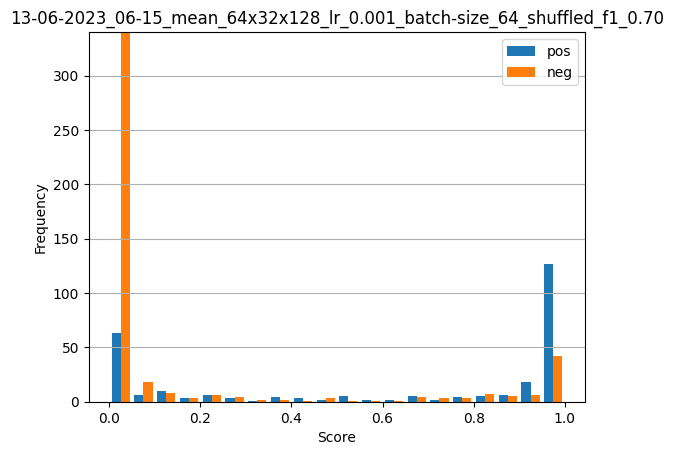

In [105]:
df = pd.DataFrame(df_data)
model_output_column_keys = df.columns[3:]
df["mean_model_score"] = df.iloc[:, 3:].mean(axis=1)

df_focus = df[(df["split"] == "gold") | (df["split"] == "gold" )]
selected_column = 16
scores_pos_class = df_focus[df_focus["actual_label"]==1.0].iloc[:,selected_column].to_list()
scores_neg_class = df_focus[df_focus["actual_label"]==0.0].iloc[:,selected_column].to_list()
model_name = str(df_focus.columns[selected_column])
bins = [x/100 for x in range(0,105, 5)]
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist([scores_pos_class, scores_neg_class], bins=bins, label=['pos', 'neg'])
                            #alpha=0.7, rwidth=0.85)
plt.grid(axis='y')#, alpha=0.75)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title(model_name)
plt.legend(loc='upper right')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [13]:
print(bins)
print(n)
print(bins[10])
p = n[0]
precision = np.array(p[10:]).sum()/(np.array(p[10:]).sum() + np.array(p[:10]).sum())
#recall = np.array(n[10:]).sum()/(np.array(n[10:]).sum() + np.array(n[:10]).sum())
print(precision)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
[[  3.  12.   6.  10.   8.   5.   7.   8.  12.  13.  16.   9.  15.  21.
   19.  18.  19.  11.  39.  26.]
 [162.  79.  25.  24.  13.   9.  14.  24.  26.  13.  15.  11.   7.   5.
    6.  12.   6.   7.   1.   0.]]
0.5
0.6967509025270758


In [45]:
df_focus

,split,datapoint_id,actual_label,13-06-2023_01-03_txt_embeddings_32x16_lr_1e-05_batch-size_16_shuffled_f1_0.76,13-06-2023_05-33_mean_128x64x32x16_lr_0.001_batch-size_8_shuffled_f1_0.71,13-06-2023_03-03_concat_128x64x32_lr_0.0001_batch-size_64_shuffled_f1_0.75,mean_model_score
2356,dev,0,0.0,0.554368,8.459569e-01,0.347134,0.582486
2357,dev,1,0.0,0.118305,5.393294e-02,0.020239,0.064159
2358,dev,2,0.0,0.337984,1.390374e-01,0.007318,0.161446
2359,dev,3,1.0,0.894770,9.811702e-01,0.957134,0.944358
2360,dev,4,1.0,0.792063,9.650500e-01,0.946339,0.901151
...,...,...,...,...,...,...,...
3170,test,543,0.0,0.158185,9.980060e-01,0.229538,0.461910
3171,test,544,0.0,0.448999,9.965972e-01,0.905345,0.783647
3172,test,545,0.0,0.033275,5.694913e-06,0.004465,0.012582
3173,test,546,0.0,0.020795,1.073266e-14,0.001465,0.007420


In [55]:
right_edge_negatives = df_focus[(df_focus["actual_label"]==0.0) & (df_focus.iloc[:,4]>=0.80)][:25]
left_edge_negatives = df_focus[(df_focus["actual_label"]==0.0) & (df_focus.iloc[:,4]<=0.10)][:25]
right_edge_positives = df_focus[(df_focus["actual_label"]==1.0) & (df_focus.iloc[:,4]>=0.80)][:25]
left_edge_positives = df_focus[(df_focus["actual_label"]==1.0) & (df_focus.iloc[:,4]<=0.10)][:25]

model_prediction_dict = {
    1: 1,
    2: 0,
    3: 1,
    4: 0,
}

df_data = {
    "tweet_id": [],
    "tweet": [],
    "true_label": [],
    "model_pred": [],
    "image": []
}
for idx, df in enumerate([right_edge_negatives, left_edge_negatives, right_edge_positives, left_edge_positives]):
    model_prediction = model_prediction_dict[idx+1]
    for idx, row in df.iterrows():
        split = row["split"]
        datapoint_id = row["datapoint_id"]
        actual_label = row["actual_label"]
        text = texts[split][datapoint_id]
        img_url = raw_dataset[split][datapoint_id]["image_url"]
        tweet_id = tweet_ids[split][datapoint_id]
        df_data["tweet_id"].append(tweet_id)
        df_data["tweet"].append(text)
        df_data["true_label"].append(actual_label)
        df_data["model_pred"].append(model_prediction)
        df_data["image"].append(img_url)



array([70, 45, 77, 24, 69,  4, 17, 42, 86, 84,  7, 89, 78, 23, 83, 55, 10,
       36, 61, 29, 90, 92, 14, 22, 62, 71, 95,  3, 51,  1, 16, 46, 15, 72,
       64, 48, 40, 18, 60, 13, 58, 63, 87, 31, 49, 25, 32, 79, 67, 28, 35,
       41, 66, 94, 43, 38,  5, 44, 81, 91, 59, 65, 52, 68, 39, 21, 74, 57,
       20,  0,  6, 54, 75, 73, 93, 47,  2,  8, 37, 19, 76, 85, 50, 26, 11,
       27, 80,  9, 33, 88, 56, 30, 12, 34, 82, 53])

In [68]:
labelling_df = pd.DataFrame(df_data)
labelling_df_randomized = labelling_df.iloc[np.random.permutation(list(range(len(labelling_df)))),:]

In [72]:
labelling_df_randomized.to_excel("labelling_datapoints_randomized.xlsx")

In [53]:
raw_dataset["train"][0]

{'tweet_id': '1222845188567003136',
 'tweet_url': 'https://twitter.com/user/status/1222845188567003136',
 'tweet_text': 'Coronavirus: DED warns pharmacies against hiking prices of face masks https://t.co/ZBvkOKiuex https://t.co/GOiAsDGP75',
 'ocr_text': 'WARNING\nM 8210\ncertain particles\nreut in eickness\nFor proper use, see\nor or box or call 3M\n0-247-3941. NIOSH\nN95\nagainst certain particies.\nheips protect\nЗи 8270\nMisuse may result in sickness\nsupervisor or box or call 3M\nor death. For proper use, see\nThis respirator helps protect\n1-800-247-3941. NIOSH\nCM0007\nLOF R17271\nAWARNING\nARNING\n3M 8210\nIC-84A 0007\nT R17271\ntin particles\nsicieness\nFapoper use, see\nbox or cel 3M\nB3C-841 NIOSH\nN95\nTC-8AU\nLOTE R17271\nwING\nN95\nM 8210\n',
 'class_label': 'Yes',
 'image_path': 'images_labeled/train/1222845188567003136.jpg',
 'image_url': 'http://pbs.twimg.com/media/EPhrN-SU4AAKvGf.jpg'}

In [35]:
dataset_dir = f"/Users/{user}/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive/data/CT23_1A_checkworthy_multimodal_english"
raw_dataset, texts, imgs, tweet_ids = load_data_splits_with_gold_dataset(dataset_dir,version)

train
dev
test
Sizes of train/test/dev/gold txt and img arrays respectively: 
2356 2356
271 271
548 548
0 0


In [34]:
def load_data_splits_with_gold_dataset(dataset_directory, version):
    raw_dataset = {"train": [], "dev": [], "test": [], "gold": []}
    texts = {"train": [], "dev": [], "test": [], "gold": []}
    imgs = {"train": [], "dev": [], "test": [], "gold": []}
    tweet_ids = {"train": [], "dev": [], "test": [], "gold": []}

    for split in ["train", "dev", "test"]:
        print(split)
        if split == "gold":
            data_dir = f"{dataset_directory}_test_gold"
            split_jsonl_file = f"{dataset_directory}_test_gold/CT23_1A_checkworthy_multimodal_english_test_gold.jsonl"
            with open(split_jsonl_file, "r") as f:
                print("yeah")
                for idx, line in enumerate(f):
                    print(idx)
                    raw_dataset[split].append(json.loads(line))
                    line = json.loads(line)
                    img_path = os.path.join(data_dir, line["image_path"])
                    imgs[split].append(Image.open(img_path))
                    texts[split].append(line["tweet_text"])
                    tweet_ids[split].append(line["tweet_id"])
        else:
            data_dir = f"{dataset_directory}_{version}"
            split_name = split if split != "test" else "dev_test"
            split_jsonl_file = f"{data_dir}/CT23_1A_checkworthy_multimodal_english_{split_name}.jsonl"
            with open(split_jsonl_file, "r") as f:
                for line in f:
                    raw_dataset[split].append(json.loads(line))
                    line = json.loads(line)
                    img_path = os.path.join(data_dir, line["image_path"])
                    imgs[split].append(Image.open(img_path))
                    texts[split].append(line["tweet_text"])
                    tweet_ids[split].append(line["tweet_id"])

    print("Sizes of train/test/dev/gold txt and img arrays respectively: ")
    print(len(texts["train"]), len(imgs["train"]))
    print(len(texts["dev"]), len(imgs["dev"]))
    print(len(texts["test"]), len(imgs["test"]))
    print(len(texts["gold"]), len(imgs["gold"]))

    return raw_dataset, texts, imgs, tweet_ids